In [1]:
import re

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
import shap
from catboost import CatBoostClassifier, Pool, metrics
from rich import print
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


## Data Cleaning & Preprocessing

### Load Data

In [2]:
df = pl.read_csv("data/ds-project-train.csv", infer_schema_length=150000)
print(df.shape)
print(df.schema)


(143280, 30)

{
    '': Int64,
    'SHIPPER': Utf8,
    'SHIPPER.ADDRESS': Utf8,
    'CONSIGNEE': Utf8,
    'CONSIGNEE.ADDRESS': Utf8,
    'ZIPCODE': Utf8,
    'NOTIFY': Utf8,
    'NOTIFY.ADDRESS': Utf8,
    'BILL.OF.LADING': Utf8,
    'ARRIVAL.DATE': Utf8,
    'WEIGHT..LB.': Utf8,
    'WEIGHT..KG.': Utf8,
    'US.PORT': Utf8,
    'QUANTITY': Utf8,
    'Q.UNIT': Utf8,
    'MEASUREMENT': Utf8,
    'M.UNIT': Utf8,
    'SHIP.REGISTERED.IN': Utf8,
    'VESSEL.NAME': Utf8,
    'CONTAINER.COUNT': Utf8,
    'PRODUCT.DETAILS': Utf8,
    'MARKS.AND.NUMBERS': Utf8,
    'COUNTRY.OF.ORIGIN': Utf8,
    'DISTRIBUTION.PORT': Utf8,
    'CARRIER.CODE': Utf8,
    'CARRIER.NAME': Utf8,
    'CARRIER.ADDRESS': Utf8,
    'CARRIER.CITY': Utf8,
    'CARRIER.STATE': Utf8,
    'CARRIER.ZIP': Utf8
}

### Drop Irrelevant Columns, Nulls, and Duplicates

In [3]:
# Select columns of interest as viable features, drop rows with missing country of origin, and remove duplicates.
df = (
    df.select(
        [
            "COUNTRY.OF.ORIGIN",
            "SHIPPER",
            "CONSIGNEE",
            "NOTIFY",
            "US.PORT",
            "SHIP.REGISTERED.IN",
            "VESSEL.NAME",
            "PRODUCT.DETAILS",
            "MARKS.AND.NUMBERS",
            "DISTRIBUTION.PORT",
            "CARRIER.CODE",
        ]
    )
    .filter(pl.col("COUNTRY.OF.ORIGIN") != "")
    .unique()
)
print(df.shape)


(128462, 11)

### Group Countries with Insufficient Data

In [4]:
# Group countries with 15 or fewer records into "Other".
df = df.with_columns(
    pl.when(
        pl.col("COUNTRY.OF.ORIGIN").is_in(
            df.groupby("COUNTRY.OF.ORIGIN")
            .agg(pl.count())
            .filter(pl.col("count") <= 15)["COUNTRY.OF.ORIGIN"]
        )
    )
    .then(pl.lit("Other"))
    .otherwise(pl.col("COUNTRY.OF.ORIGIN"))
    .alias("COUNTRY.OF.ORIGIN")
)

print(
    df.groupby("COUNTRY.OF.ORIGIN")
    .agg([pl.count().alias("count")])
    .sort("count", descending=True)
    .rows()
)


[
    ('China', 93378),
    ('Hong Kong', 4829),
    ('South Korea', 4134),
    ('Singapore', 4027),
    ('Oman', 2342),
    ('Panama', 2247),
    ('China Taiwan', 2142),
    ('Malaysia', 1956),
    ('Guatemala', 1526),
    ('Costa Rica', 1264),
    ('Spain', 1231),
    ('India', 1189),
    ('Japan', 781),
    ('Sri Lanka', 743),
    ('Pakistan', 670),
    ('Chile', 656),
    ('Germany', 622),
    ('Thailand', 546),
    ('Vietnam', 512),
    ('Mexico', 366),
    ('Italy', 329),
    ('Egypt', 287),
    ('American Samoa', 252),
    ('Bahamas', 245),
    ('Brazil', 243),
    ('Honduras', 242),
    ('Belgium', 192),
    ('Jamaica', 183),
    ('United Kingdom', 163),
    ('Sweden', 149),
    ('Other', 125),
    ('Canada', 124),
    ('Dominican Republic', 118),
    ('Netherlands', 96),
    ('Colombia', 91),
    ('Haiti', 83),
    ('France', 60),
    ('South Africa', 55),
    ('Israel', 55),
    ('Romania', 43),
    ('Portugal', 42),
    ('Greece', 38),
    ('Argentina', 33),
    ('Jordan', 31),
    ('Turkey', 22)
]

### Clean Text Fields

In [5]:
# Clean text in product details and marks and numbers.
def clean_text(text):
    # Remove numbers and special characters.
    text = re.sub(r"[\d\W]+", " ", text)
    # Remove words with length less than 3.
    text = re.sub(r"\b\w{1,2}\b", " ", text)
    # Remove extra spaces.
    return re.sub(" +", " ", text).strip()

df = df.with_columns(
    [
        pl.col("PRODUCT.DETAILS").apply(clean_text),
        pl.col("MARKS.AND.NUMBERS").apply(clean_text),
    ]
)


### Train / Val Split

In [6]:
X = df.drop("COUNTRY.OF.ORIGIN").to_numpy()
y = df["COUNTRY.OF.ORIGIN"].to_numpy()

# Train / val split.
X_train, X_val, y_train, y_val = train_test_split(
    X, y, train_size=0.8, stratify=y, random_state=42
)


## Model Training

In [7]:
model_path = "model/cbc_model_0.dump"
try:
    model = CatBoostClassifier().load_model(model_path)
except:
    model = CatBoostClassifier(
        custom_loss=[metrics.Accuracy()],
        logging_level='Silent',
        iterations=100,
        learning_rate=0.15,
        od_type='Iter',
        od_wait=10,
        use_best_model=True,
        random_seed=42
    )

    model.fit(
        X_train, y_train,
        cat_features=np.arange(0, X.shape[1]),
        eval_set=(X_val, y_val),
        logging_level='Verbose',
        plot=True,
    )

    model.save_model(model_path)


## Model Evaluation & Testing

### Get Feature Importance

In [8]:
feature_importances = model.get_feature_importance()
feature_names = df.drop("COUNTRY.OF.ORIGIN").columns
print(sorted(zip(feature_importances, feature_names), reverse=True))


[
    (30.877119874408837, 'VESSEL.NAME'),
    (21.669175780625554, 'NOTIFY'),
    (14.48755558739891, 'CARRIER.CODE'),
    (7.32213319910301, 'US.PORT'),
    (7.091041114510436, 'MARKS.AND.NUMBERS'),
    (6.70873384828756, 'SHIP.REGISTERED.IN'),
    (6.124262948420093, 'SHIPPER'),
    (3.84847369385476, 'CONSIGNEE'),
    (1.4248928444962885, 'PRODUCT.DETAILS'),
    (0.4466111088944798, 'DISTRIBUTION.PORT')
]

### Calculate SHAP Values

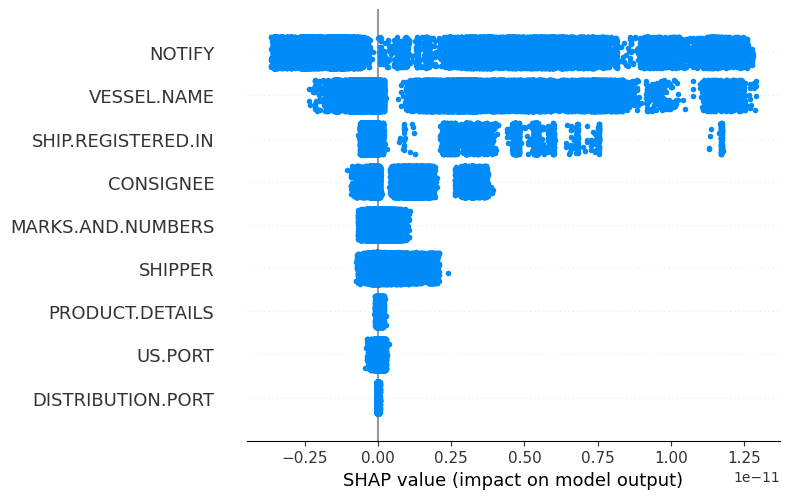

In [9]:
cat_features = list(range(0, X.shape[1]))
shap_values = model.get_feature_importance(
    Pool(X, y, cat_features=cat_features), type="ShapValues"
)[:, :, :-1]

# Sum SHAP values over all classes and plot.
shap_values_summed = shap_values.sum(axis=1)[:, :-1]
shap.summary_plot(shap_values_summed, feature_names=feature_names)


### Load Test Data

In [10]:
# Import validation data for testing.
df_test = pl.read_csv("data/ds-project-validation.csv", infer_schema_length=50000)

# Select columns from training data, filter out empty country of origin, and remove duplicates.
df_test = (
    df_test.select(
        [
            "COUNTRY.OF.ORIGIN",
            "SHIPPER",
            "CONSIGNEE",
            "NOTIFY",
            "US.PORT",
            "SHIP.REGISTERED.IN",
            "VESSEL.NAME",
            "PRODUCT.DETAILS",
            "MARKS.AND.NUMBERS",
            "DISTRIBUTION.PORT",
            "CARRIER.CODE",
        ]
    )
    .filter(pl.col("COUNTRY.OF.ORIGIN") != "")
    .unique()
)

# Group countries not in training data into "Other".
df_test = df_test.with_columns(
        pl.when(pl.col("COUNTRY.OF.ORIGIN").is_in(df['COUNTRY.OF.ORIGIN'].unique()))
        .then(pl.col("COUNTRY.OF.ORIGIN"))
        .otherwise(pl.lit("Other"))
        .alias("COUNTRY.OF.ORIGIN")
)

# Clean text in product details and marks and numbers.
df_test = df_test.with_columns(
    [
        pl.col("PRODUCT.DETAILS").apply(clean_text),
        pl.col("MARKS.AND.NUMBERS").apply(clean_text),
    ]
)


### Run Model

In [11]:
# Use model to predict country of origin.
df_test = (
    df_test.hstack(
        pl.from_numpy(
            model.predict(df_test.drop("COUNTRY.OF.ORIGIN").to_numpy()).reshape(-1, 1)
        )
    )
    .rename({"column_0": "PREDICTION"})
    .with_columns(pl.col("PREDICTION").apply(lambda x: str(x)))
)

true_labels = df_test["COUNTRY.OF.ORIGIN"].to_numpy()
predicted_labels = df_test["PREDICTION"].to_numpy()

# Show accuracy and generate classification report.
print("Accuracy:", accuracy_score(true_labels, predicted_labels))
print("\nClassification Report:\n", classification_report(true_labels, predicted_labels))


Accuracy: 0.949134548811447

Classification Report:
                     precision    recall  f1-score   support

    American Samoa       0.98      1.00      0.99        84
         Argentina       1.00      0.27      0.43        11
           Bahamas       0.65      0.73      0.69        95
           Belgium       0.83      0.62      0.71        63
            Brazil       0.80      0.80      0.80        81
            Canada       1.00      0.60      0.75        43
             Chile       0.93      1.00      0.96       244
             China       0.97      0.99      0.98     31252
      China Taiwan       0.88      0.79      0.83       760
          Colombia       0.80      0.65      0.72        37
        Costa Rica       1.00      1.00      1.00       444
Dominican Republic       0.80      0.56      0.66        36
             Egypt       0.98      0.98      0.98        81
            France       0.33      0.06      0.10        17
           Germany       0.90      0.88      0.89       199
            Greece       0.92      0.80      0.86        15
         Guatemala       0.98      0.97      0.97       555
             Haiti       0.89      0.89      0.89        19
          Honduras       0.92      0.95      0.93        96
         Hong Kong       0.85      0.69      0.76      1662
             India       0.85      0.81      0.82       380
            Israel       0.73      0.65      0.69        17
             Italy       0.89      0.77      0.83       133
           Jamaica       0.76      0.76      0.76        72
             Japan       0.92      0.93      0.93       283
            Jordan       1.00      0.67      0.80         9
          Malaysia       0.90      0.88      0.89       689
            Mexico       0.94      0.85      0.90       117
       Netherlands       1.00      0.19      0.32        31
              Oman       0.92      0.89      0.90       761
             Other       0.85      0.35      0.49        49
          Pakistan       0.70      0.86      0.77       226
            Panama       0.90      0.92      0.91       746
          Portugal       0.75      0.15      0.25        20
           Romania       1.00      0.94      0.97        16
         Singapore       0.89      0.92      0.90      1381
      South Africa       1.00      0.94      0.97        18
       South Korea       0.89      0.85      0.87      1422
             Spain       0.89      0.95      0.91       424
         Sri Lanka       0.91      0.84      0.87       249
            Sweden       1.00      0.98      0.99        58
          Thailand       0.93      0.90      0.92       209
            Turkey       1.00      0.75      0.86         8
    United Kingdom       0.94      0.70      0.80        47
           Vietnam       0.86      0.61      0.71       171

          accuracy                           0.95     43330
         macro avg       0.89      0.76      0.80     43330
      weighted avg       0.95      0.95      0.95     43330

### Generate Confusion Matrix

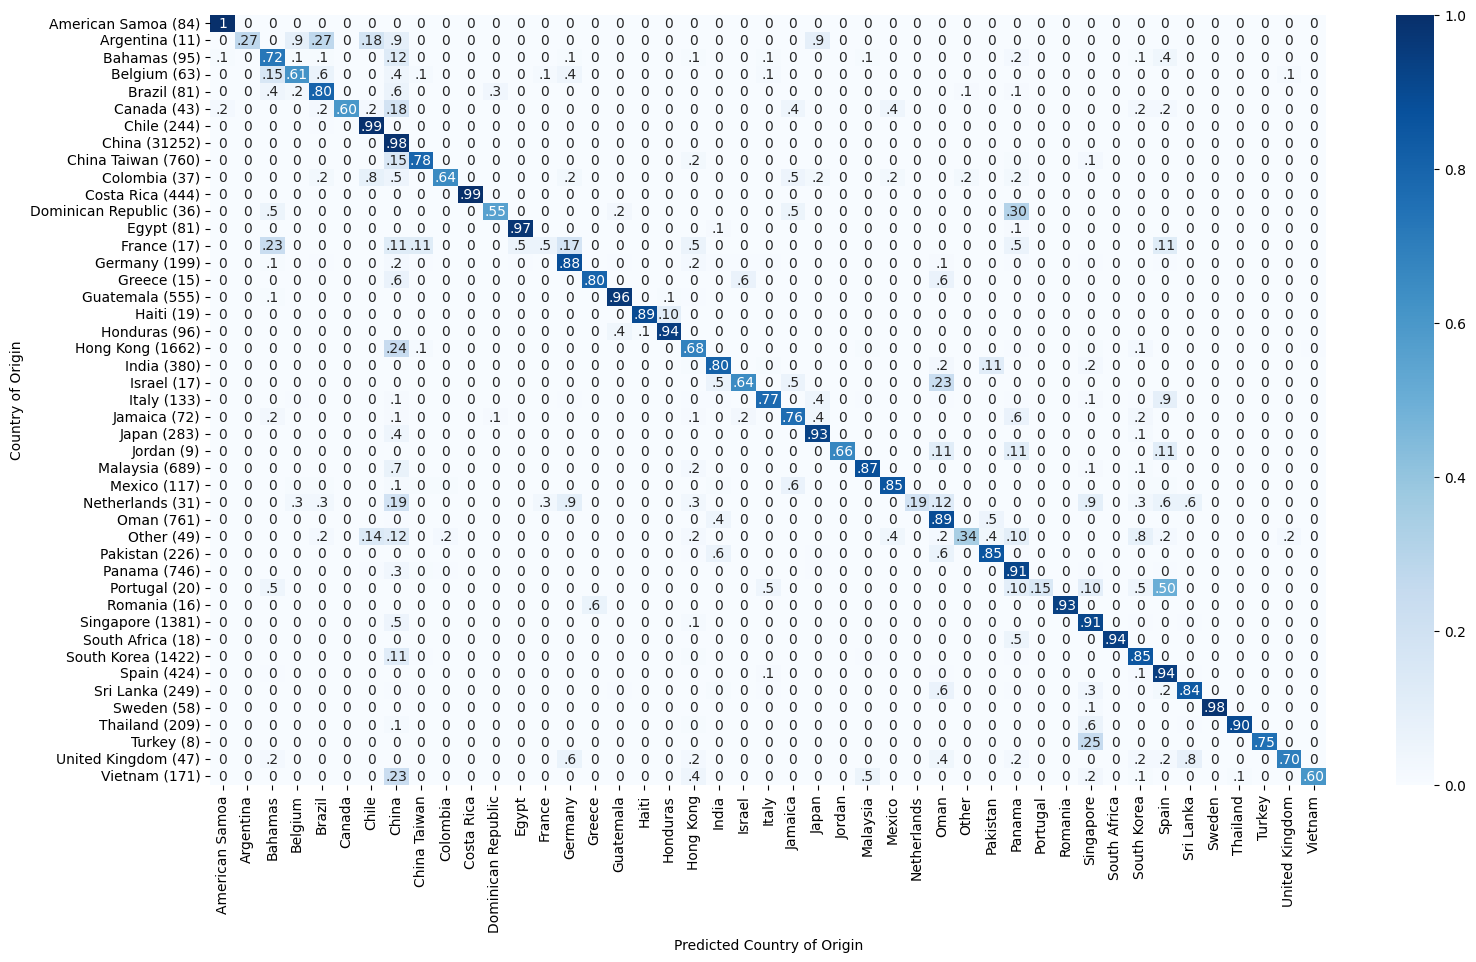

In [12]:
# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Normalize the confusion matrix by class
conf_matrix_normalized = (
    conf_matrix.astype("float") / conf_matrix.sum(axis=1)[:, np.newaxis]
)

# Get value counts for each country to use in data labels
country_counts = dict(df_test["COUNTRY.OF.ORIGIN"].value_counts().rows())
classes = np.unique(np.concatenate((true_labels, predicted_labels)))
class_labels = [f"{country} ({country_counts[country]})" for country in classes]

# Custom formatting to make data more readable
annot = np.array(
    [
        [
            "1"
            if value == 1
            else f".{int(value * 100)}"
            if int(value * 100) != 0
            else "0"
            for value in row
        ]
        for row in conf_matrix_normalized
    ]
)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(18, 10))
sns.heatmap(
    conf_matrix_normalized,
    annot=annot,
    fmt="",
    cmap="Blues",
    xticklabels=classes,
    yticklabels=class_labels,
)
plt.xlabel("Predicted Country of Origin")
plt.ylabel("Country of Origin")
plt.show()
